In [1]:
# only permit max cut

canonical_order = ['BarabasiAlbert', 'ErdosRenyi', 'PowerlawCluster', 'WattsStrogatz',  'MUTAG', 'ENZYMES', 'PROTEINS',   'IMDB-BINARY', 'COLLAB']
def reorder(df, canonical_order=canonical_order, by='dataset', extras=['dataset','gen_n', 'gen_n_max'], secondary='gen_n', columns=None):
    df['dataset_name_order'] = df[by].map({name: i for i, name in enumerate(canonical_order)})
    if secondary is not None:
        df = df.sort_values(by=['dataset_name_order', secondary])
    else:
        df = df.sort_values(by=['dataset_name_order'])

    df.drop('dataset_name_order', axis =1, inplace=True)

    if columns:
        return df[columns ]
    else:
        return df

In [2]:
import os
os.listdir('/home/bcjexu/maxcut-80/bespoke-gnn4do/training_runs')

['legacy',
 'Testing',
 '230928_snapshot',
 'LiftMP_runs',
 '230924_hparam2',
 '230927_snapshot',
 '230928_runs',
 '230924_hparam',
 '230924_hparam_TU_multiarch',
 '230924_hparam_TU',
 '230926_finetune_ER_runs']

In [3]:
print(list(os.path.join('230928_runs', x) for x in os.listdir('/home/bcjexu/maxcut-80/bespoke-gnn4do/training_runs/230928_runs')))

['230928_runs/230925_TUsmall_GAT_VC', '230928_runs/230925_TUsmall_GIN_cut', '230928_runs/230925_generated_preset_cut', '230928_runs/230925_TUsmall_GAT_cut', '230928_runs/230925_TUsmall_liftMP_cut', '230928_runs/230925_TUsmall_GCNN_VC', '230928_runs/230925_TUsmall_GCNN_cut', '230928_runs/230925_generated_liftMP_VC', '230928_runs/230925_generated_preset_VC', '230928_runs/230925_TUsmall_liftMP_VC', '230928_runs/230925_TUsmall_GatedGCNN_VC', '230928_runs/230925_TUsmall_VC_32', '230928_runs/230925_TUlarge_liftMP_cut', '230928_runs/230925_TUlarge_liftMP_VC', '230928_runs/230925_generated_liftMP_cut', '230928_runs/230925_TUsmall_GatedGCNN_cut']


In [4]:
run_folders = ['LiftMP_runs', '230927_snapshot/230925_TUsmall_GAT_VC', '230927_snapshot/230925_TUsmall_GIN_VC', 
               '230927_snapshot/230925_generated_preset_cut', '230927_snapshot/230925_TUlarge_all_cut', '230927_snapshot/230925_TUsmall_GCNN_VC',
                 '230927_snapshot/230925_generated_liftMP_VC', '230927_snapshot/230925_TUlarge_all_VC', '230927_snapshot/230925_generated_preset_VC', 
                 '230927_snapshot/230925_TUsmall_liftMP_VC', '230927_snapshot/230925_TUsmall_GatedGCNN_VC', '230927_snapshot/230925_generated_liftMP_cut']

run_folders = ['230928_snapshot/230925_TUsmall_GAT_VC', '230928_snapshot/230925_TUsmall_GIN_cut', 
               '230928_snapshot/230925_generated_preset_cut', '230928_snapshot/230925_TUsmall_GAT_cut', 
               '230928_snapshot/230925_TUsmall_liftMP_cut', '230928_snapshot/230925_TUsmall_GCNN_VC', 
               '230928_snapshot/230925_TUsmall_GCNN_cut', '230928_snapshot/230925_generated_liftMP_VC', 
               '230928_snapshot/230925_generated_preset_VC', '230928_snapshot/230925_TUsmall_liftMP_VC', '230928_snapshot/230925_TUsmall_GatedGCNN_VC', 
               '230928_snapshot/230925_TUsmall_VC_32', '230928_snapshot/230925_generated_liftMP_cut', '230928_snapshot/230925_TUsmall_GatedGCNN_cut']

run_folders = ['230928_runs/230925_TUsmall_GAT_VC', '230928_runs/230925_TUsmall_GIN_cut', 
               '230928_runs/230925_generated_preset_cut', '230928_runs/230925_TUsmall_GAT_cut', 
               '230928_runs/230925_TUsmall_liftMP_cut', '230928_runs/230925_TUsmall_GCNN_VC', 
               '230928_runs/230925_TUsmall_GCNN_cut', '230928_runs/230925_generated_liftMP_VC', '230928_runs/230925_generated_preset_VC', 
               '230928_runs/230925_TUsmall_liftMP_VC', '230928_runs/230925_TUsmall_GatedGCNN_VC', '230928_runs/230925_TUsmall_VC_32', 
               '230928_runs/230925_TUlarge_liftMP_cut', '230928_runs/230925_TUlarge_liftMP_VC', '230928_runs/230925_generated_liftMP_cut', '230928_runs/230925_TUsmall_GatedGCNN_cut']



In [5]:
import json
import pandas as pd
import numpy as np

folder_path = '/home/bcjexu/maxcut-80/bespoke-gnn4do/training_runs'
model_list = [os.path.join(folder_path, run_folder, x) for run_folder in run_folders for x in os.listdir(os.path.join(folder_path, run_folder))  ]


rows = []
numtimes = 0

errored = []
for model_folder in model_list:
    try:
        with open(os.path.join(model_folder, 'params.txt'), 'r') as f:
            model_args = json.load(f)
        if model_args['problem_type'] != 'max_cut':
            continue
        
        losses = np.load(os.path.join(model_folder, 'valid_scores.npy'))
        test_losses = np.load(os.path.join(model_folder, 'test_scores.npy'))
        modeldict = model_args #{x: model_args[x] for x in params}
        modeldict['max_valid_score'] = max(losses)
        modeldict['max_valid_epoch'] = np.argmax(losses)
        modeldict['scores'] = test_losses[np.argmax(losses)]
        modeldict['baseline'] = False


        scorefile = [x for x in os.listdir(model_folder) if x.startswith("time_and_score")]
        #assert(len(scorefile) <=1)
        if len(scorefile) >= 1:
            times, scores = np.load(os.path.join(model_folder, scorefile[0]))
            modeldict['time_per_pred'] = np.average(times)
            numtimes+=1
        else: 
            # load a dummy
            #times, scores = np.load('/home/bcjexu/maxcut-80/bespoke-gnn4do/training_runs/230924_hparam/paramhash:0a0656a369a5b8e4a4be27e0d04fb3b8c161e7b630caf99b8eaeedcddd6a2b18/time_and_score@@test_results_2023-09-28_01:23:33.np.npy')
            modeldict['time_per_pred'] = np.nan
        
        

        rows.append(modeldict)
        
    except Exception as e:
        print(f'{e} is wrong w/ {model_folder}')
        errored.append(model_folder)

In [6]:
numtimes

52

In [7]:
# load in baselines
baselines = pd.read_csv('mc_baseline_scores.csv')

gen_n_dict = dict(zip([50, 100, 400], [[50, 100], [100, 200],[400, 500]]))

# unwind them 
for i, baseline in baselines.iterrows():
    #print(baseline.index)
    for col in baselines.keys():
        if col == 'Unnamed: 0':
            continue
        if baseline['Unnamed: 0'] == 'edge count':
            continue
        ds = col
        gen_n = np.nan
        if len(col.split('@@')) > 1:
            ds, gen_n = col.split('@@')
            gen_n = gen_n_dict[int(gen_n)]

        row = {'dataset': ds, 'gen_n': gen_n, 'model_type': baseline['Unnamed: 0'], 'scores': baseline[col], 'baseline': True}
        #print(row)
        rows.append(row)


In [8]:
len(errored)

0

In [9]:
df = pd.DataFrame.from_records(rows)

In [10]:
df

,problem_type,seed,prefix,model_type,num_layers,repeat_lift_layers,num_layers_project,rank,dropout,hidden_channels,...,pe_dimension,split_seed,log_dir,device,max_valid_score,max_valid_epoch,scores,baseline,time_per_pred,valid_fraction
0,max_cut,0.0,230925_TUsmall_GIN_cut,GIN,8.0,NaN,4.0,32.0,0.0,32.0,...,8.0,0.0,training_runs/230925_TUsmall_GIN_cut/paramhash...,cuda,90.761261,45.0,91.986607,False,NaN,NaN
1,max_cut,0.0,230925_TUsmall_GIN_cut,GIN,8.0,NaN,4.0,4.0,0.0,32.0,...,2.0,0.0,training_runs/230925_TUsmall_GIN_cut/paramhash...,cuda,69.600000,4.0,73.766667,False,NaN,NaN
2,max_cut,0.0,230925_TUsmall_GIN_cut,GIN,8.0,NaN,4.0,16.0,0.0,32.0,...,8.0,0.0,training_runs/230925_TUsmall_GIN_cut/paramhash...,cuda,1184.341000,0.0,1277.113000,False,0.019566,NaN
3,max_cut,0.0,230925_TUsmall_GIN_cut,GIN,8.0,NaN,4.0,32.0,0.0,32.0,...,8.0,0.0,training_runs/230925_TUsmall_GIN_cut/paramhash...,cuda,10.578947,0.0,9.421053,False,0.013050,NaN
4,max_cut,0.0,230925_TUsmall_GIN_cut,GIN,16.0,NaN,4.0,4.0,0.0,32.0,...,2.0,0.0,training_runs/230925_TUsmall_GIN_cut/paramhash...,cuda,69.550000,1.0,74.466667,False,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
800,NaN,NaN,NaN,SDP proj,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,NaN,NaN
801,NaN,NaN,NaN,SDP proj,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,97.495000,True,NaN,NaN
802,NaN,NaN,NaN,SDP proj,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,NaN,NaN
803,NaN,NaN,NaN,SDP proj,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,NaN,NaN


In [11]:
df['gen_n_list'] = df.gen_n
df['gen_n_max'] = df.gen_n_list.apply(lambda x: int(x[1]) if isinstance(x,list) else x)
df.gen_n = df.gen_n.apply(lambda x: int(x[0]) if isinstance(x,list) else x)


In [12]:
df.keys()
# 'problem_type', 'seed',  'prefix', 'RB_n', 'RB_k', 'log_dir',
relevant_keys = [ 'model_type', 'num_layers',
       'repeat_lift_layers', 'num_layers_project', 'rank', 'vc_penalty', 'gen_n',
       'dataset', 'infinite',  'positional_encoding', 'pe_dimension',
       'max_valid_score', 'max_valid_epoch',
       'scores']

In [13]:
df

,problem_type,seed,prefix,model_type,num_layers,repeat_lift_layers,num_layers_project,rank,dropout,hidden_channels,...,log_dir,device,max_valid_score,max_valid_epoch,scores,baseline,time_per_pred,valid_fraction,gen_n_list,gen_n_max
0,max_cut,0.0,230925_TUsmall_GIN_cut,GIN,8.0,NaN,4.0,32.0,0.0,32.0,...,training_runs/230925_TUsmall_GIN_cut/paramhash...,cuda,90.761261,45.0,91.986607,False,NaN,NaN,100,100.0
1,max_cut,0.0,230925_TUsmall_GIN_cut,GIN,8.0,NaN,4.0,4.0,0.0,32.0,...,training_runs/230925_TUsmall_GIN_cut/paramhash...,cuda,69.600000,4.0,73.766667,False,NaN,NaN,100,100.0
2,max_cut,0.0,230925_TUsmall_GIN_cut,GIN,8.0,NaN,4.0,16.0,0.0,32.0,...,training_runs/230925_TUsmall_GIN_cut/paramhash...,cuda,1184.341000,0.0,1277.113000,False,0.019566,NaN,100,100.0
3,max_cut,0.0,230925_TUsmall_GIN_cut,GIN,8.0,NaN,4.0,32.0,0.0,32.0,...,training_runs/230925_TUsmall_GIN_cut/paramhash...,cuda,10.578947,0.0,9.421053,False,0.013050,NaN,100,100.0
4,max_cut,0.0,230925_TUsmall_GIN_cut,GIN,16.0,NaN,4.0,4.0,0.0,32.0,...,training_runs/230925_TUsmall_GIN_cut/paramhash...,cuda,69.550000,1.0,74.466667,False,NaN,NaN,100,100.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
800,NaN,NaN,NaN,SDP proj,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,True,NaN,NaN,NaN,NaN
801,NaN,NaN,NaN,SDP proj,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,97.495000,True,NaN,NaN,NaN,NaN
802,NaN,NaN,NaN,SDP proj,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,True,NaN,NaN,NaN,NaN
803,NaN,NaN,NaN,SDP proj,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,True,NaN,NaN,"[400, 500]",500.0


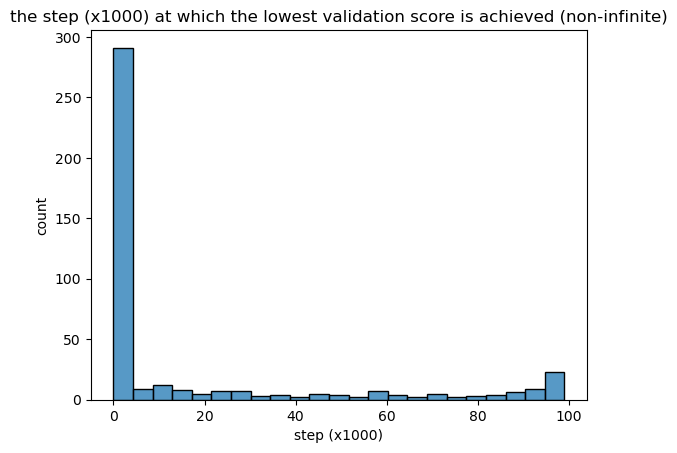

,model_type,num_layers,repeat_lift_layers,num_layers_project,rank,vc_penalty,gen_n,dataset,infinite,positional_encoding,pe_dimension,max_valid_score,max_valid_epoch,scores
176,GAT,8.0,NaN,4.0,16.0,NaN,100.0,PROTEINS,False,laplacian_eigenvector,8.0,96.481982,99.0,98.424107
183,GAT,8.0,NaN,4.0,16.0,NaN,100.0,ENZYMES,False,laplacian_eigenvector,8.0,73.850000,91.0,78.850000
186,GAT,16.0,NaN,4.0,16.0,NaN,100.0,PROTEINS,False,laplacian_eigenvector,8.0,94.436937,94.0,96.308036
189,GAT,8.0,NaN,4.0,4.0,NaN,100.0,ENZYMES,False,random_walk,2.0,75.250000,91.0,80.733333
190,GAT,16.0,NaN,4.0,16.0,NaN,100.0,ENZYMES,False,laplacian_eigenvector,8.0,74.733333,99.0,80.050000
193,GAT,8.0,NaN,4.0,4.0,NaN,100.0,COLLAB,False,laplacian_eigenvector,2.0,2424.335000,95.0,2611.829000
201,GAT,16.0,NaN,4.0,32.0,NaN,100.0,PROTEINS,False,random_walk,8.0,90.941441,94.0,92.763393
208,GAT,16.0,NaN,4.0,4.0,NaN,100.0,ENZYMES,False,random_walk,2.0,69.566667,99.0,74.466667
211,GAT,16.0,NaN,4.0,8.0,NaN,100.0,ENZYMES,False,laplacian_eigenvector,4.0,72.950000,93.0,78.366667
225,GAT,16.0,NaN,4.0,16.0,NaN,100.0,MUTAG,False,laplacian_eigenvector,8.0,29.684211,99.0,26.315789


In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.histplot(df[df.infinite==False].max_valid_epoch)
plt.title('the step (x1000) at which the lowest validation score is achieved (non-infinite)')
plt.xlabel("step (x1000)")
plt.ylabel('count')
plt.show()
df[(df.max_valid_epoch > 90) & (df.infinite==False)][relevant_keys] #.to_csv('230925_checkup_late_bloomers.csv')

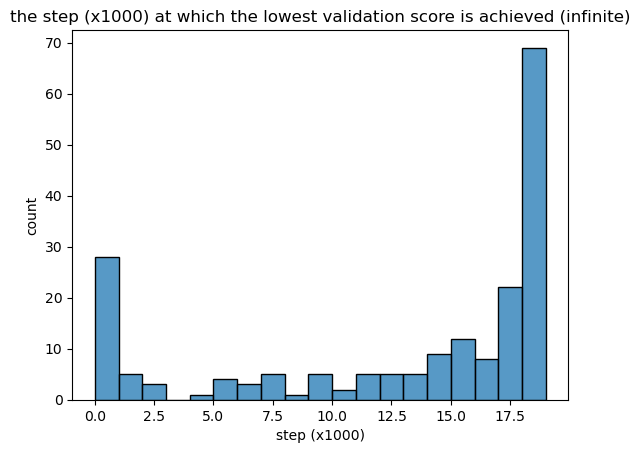

,model_type,num_layers,repeat_lift_layers,num_layers_project,rank,vc_penalty,gen_n,dataset,infinite,positional_encoding,pe_dimension,max_valid_score,max_valid_epoch,scores
88,GIN,8.0,NaN,4.0,8.0,NaN,400.0,ErdosRenyi,True,random_walk,4.0,15818.7100,19.0,15818.4200
90,GCNN,8.0,NaN,4.0,8.0,NaN,50.0,ErdosRenyi,True,random_walk,4.0,486.8070,19.0,486.9650
113,GAT,8.0,NaN,4.0,8.0,NaN,400.0,ErdosRenyi,True,random_walk,4.0,16126.8980,19.0,16125.7330
125,GAT,8.0,NaN,4.0,16.0,NaN,100.0,ErdosRenyi,True,random_walk,8.0,1977.4605,19.0,1977.8215
137,GAT,8.0,NaN,4.0,4.0,NaN,50.0,ErdosRenyi,True,random_walk,2.0,524.3820,19.0,524.2270
138,GAT,8.0,NaN,4.0,16.0,NaN,400.0,ErdosRenyi,True,random_walk,8.0,16219.8760,19.0,16220.4480
140,GAT,16.0,NaN,4.0,4.0,NaN,50.0,ErdosRenyi,True,random_walk,2.0,525.6640,19.0,525.5190
141,GAT,8.0,NaN,4.0,16.0,NaN,50.0,ErdosRenyi,True,random_walk,8.0,524.5980,19.0,524.4560
143,GAT,8.0,NaN,4.0,4.0,NaN,100.0,ErdosRenyi,True,random_walk,2.0,1979.3225,19.0,1979.4475
157,GAT,16.0,NaN,4.0,4.0,NaN,100.0,ErdosRenyi,True,random_walk,2.0,1911.7305,19.0,1910.2635


In [15]:
sns.histplot(df[df.infinite!=False].max_valid_epoch, bins=range(20))
plt.title('the step (x1000) at which the lowest validation score is achieved (infinite)')
plt.xlabel("step (x1000)")
plt.ylabel('count')
plt.show()
df[(df.max_valid_epoch > 18) & (df.infinite!=False)][relevant_keys] #.to_csv('230925_checkup_late_bloomers.csv')

In [16]:
df.loc[df[df.baseline == False].groupby(['dataset', 'gen_n'])['scores'].idxmax()][relevant_keys]

,model_type,num_layers,repeat_lift_layers,num_layers_project,rank,vc_penalty,gen_n,dataset,infinite,positional_encoding,pe_dimension,max_valid_score,max_valid_epoch,scores
474,LiftMP,16.0,NaN,4.0,16.0,NaN,50.0,BarabasiAlbert,True,random_walk,8.0,351.475000,14.0,351.488000
473,LiftMP,16.0,NaN,4.0,32.0,NaN,100.0,BarabasiAlbert,True,random_walk,8.0,717.208000,19.0,717.193000
461,LiftMP,16.0,NaN,4.0,8.0,NaN,400.0,BarabasiAlbert,True,random_walk,4.0,2197.661000,7.0,2198.109000
292,LiftMP,8.0,NaN,4.0,32.0,NaN,100.0,COLLAB,False,random_walk,8.0,2435.369000,88.0,2622.515000
309,LiftMP,8.0,NaN,4.0,8.0,NaN,100.0,ENZYMES,False,laplacian_eigenvector,4.0,75.766667,21.0,81.416667
522,LiftMP,16.0,NaN,4.0,16.0,NaN,50.0,ErdosRenyi,True,random_walk,8.0,528.894000,17.0,528.998000
505,LiftMP,16.0,NaN,4.0,16.0,NaN,100.0,ErdosRenyi,True,random_walk,8.0,1995.012500,18.0,1995.051500
445,LiftMP,16.0,NaN,4.0,32.0,NaN,400.0,ErdosRenyi,True,random_walk,8.0,16386.919000,4.0,16387.455000
264,LiftMP,8.0,NaN,4.0,16.0,NaN,100.0,IMDB-BINARY,False,random_walk,8.0,84.955000,2.0,97.485000
268,LiftMP,8.0,NaN,4.0,32.0,NaN,100.0,MUTAG,False,laplacian_eigenvector,8.0,31.368421,0.0,27.947368


In [17]:
df.gen_n = df.gen_n.fillna(100)
df.gen_n_max = df.gen_n_max.fillna(100)

In [18]:
from collections import Counter
Counter(df.dataset)

Counter({'ErdosRenyi': 147,
         'PROTEINS': 89,
         'ENZYMES': 89,
         'COLLAB': 89,
         'MUTAG': 89,
         'IMDB-BINARY': 89,
         'PowerlawCluster': 51,
         'WattsStrogatz': 51,
         'BarabasiAlbert': 51,
         'REDDIT-MULTI-5K': 17,
         'REDDIT-MULTI-12K': 17,
         'REDDIT-BINARY': 17,
         'RANDOM': 9})

In [19]:
# test models

models_for_test = []

In [20]:
dataset_by_arc = pd.DataFrame()
dss = ['BarabasiAlbert', 'ErdosRenyi', 'PowerlawCluster', 'WattsStrogatz']
mts = ['SDP proj', 'gurobi_2.0', 'gurobi_4.0', 'gurobi_8.0', 'vertex count']



for (mt, ds, gen_n), group in df[(df.infinite == False) | (df.dataset == 'ErdosRenyi')].groupby(['model_type', 'dataset', 'gen_n']):
    if mt in mts:
        continue
    if all(group['scores'].isna()):
        continue

    if ds not in dss:
        gen_n = ""

    #print(mt, ds, gen_n)
    if ds in dss:
        dataset_by_arc.at[f'{ds}, {gen_n}', mt] = f'{group["scores"].max():0.1f} ({df.loc[group["scores"].idxmax()]["time_per_pred"]*1000:0.0f})'
        dataset_by_arc.at[f'{ds}, {gen_n}', 'gen_n'] = gen_n
        dataset_by_arc.at[f'{ds}, {gen_n}', 'dataset'] = ds
    else: 
        dataset_by_arc.at[f'{ds}', mt] = f'{group["scores"].max():0.1f} ({df.loc[group["scores"].idxmax()]["time_per_pred"]*1000:0.0f})'
        dataset_by_arc.at[f'{ds}', 'dataset'] = ds

    try:
        models_for_test.append((df.loc[group['scores'].idxmax()]['log_dir'], df.loc[group['scores'].idxmax()]['dataset'], df.loc[group['scores'].idxmax()]['gen_n'])) 
    except Exception as e:
        print(f'{e}')



#dataset_by_arc['dataset'] = dataset_by_arc.index
reorder(dataset_by_arc[[k for k in dataset_by_arc.keys() if k not in ['SDP lift', 'edge count']]], by='dataset', columns = ['dataset', 'gen_n',  'GAT', 
                                                                                                                            'GCNN', 'GIN', 'GatedGCNN', 'LiftMP']).to_csv('Table1_maxcut.csv', index=False) #.style.highlight_max(color = 'green', axis = 1)

In [21]:
dataset_by_arc = pd.DataFrame()
mts = ['GAT', 'GCNN', 'GIN', 'GatedGCNN']
dss = ['BarabasiAlbert', 'ErdosRenyi', 'PowerlawCluster', 'WattsStrogatz']

for (mt, ds, gen_n, gen_nmax), group in df[~df.model_type.isin(mts)].groupby(['model_type', 'dataset', 'gen_n', 'gen_n_max']):


    if all(group['scores'].isna()):
        continue
    if ds not in dss:
        gen_n = ""
        gen_nmax = ""
    #print(mt, ds, gen_n)
    if ds in dss:
        k = f'{ds}_{gen_n}'
    else:
        k = ds
    dataset_by_arc.at[k, 'Type'] = ds
    dataset_by_arc.at[k, 'Nmin'] = gen_n
    dataset_by_arc.at[k, 'Nmax'] = gen_nmax
    if mt != 'LiftMP':
        dataset_by_arc.at[k, mt] = group['scores'].max()
    else:
        dataset_by_arc.at[k, mt] = f'{group["scores"].max():0.1f} ({df.loc[group["scores"].idxmax()]["time_per_pred"]*1000:0.0f})'
    try:
        models_for_test.append((df.loc[group['scores'].idxmax()]['log_dir'], df.loc[group['scores'].idxmax()]['dataset'], df.loc[group['scores'].idxmax()]['gen_n'])) 
    except Exception as e:
        print(f'{e}')

#dataset_by_arc.rename(columns={'Nikos': 'CustomLiftProject'}, inplace=True)
reorder(dataset_by_arc[[k for k in dataset_by_arc.keys() if k not in [ 'SDP lift', 'vertex count']]], by='Type', secondary='Nmin').round(1).to_csv('Table2_maxcut.csv') #.style.highlight_max(color = 'green', axis = 1)

In [22]:
for x in models_for_test:
    print(x)

('training_runs/230925_TUsmall_GAT_cut/paramhash:229fdd4defd5beb6d5299b78886340673e646af2288d38d62612ac1d54d79e35', 'COLLAB', 100.0)
('training_runs/230925_TUsmall_GAT_cut/paramhash:13208a7aa1df13fe6517cb5e1ee7d27df9e4436f2cfbce9ddf35ffee6440d8a5', 'ENZYMES', 100.0)
('training_runs/230925_generated_preset_cut/paramhash:98627c0c9f1729b615470a023c62c47b0d4265e0180843f09678d0dccf98f1e3', 'ErdosRenyi', 50.0)
('training_runs/230925_generated_preset_cut/paramhash:29022497978cacef4919cb917e4407ea28c15be66dbeb1afebecce605652db9d', 'ErdosRenyi', 100.0)
('training_runs/230925_generated_preset_cut/paramhash:45aa5663131bdb65f33407dc287ffd53552b8b7bc847585738935981839e6d70', 'ErdosRenyi', 400.0)
('training_runs/230925_TUsmall_GAT_cut/paramhash:d2dd2f61687ba72355c18cbd0a85fb86a20a8d27035a36732bdac120ce749985', 'IMDB-BINARY', 100.0)
('training_runs/230925_TUsmall_GAT_cut/paramhash:a4ffb64d114dba179d14cfea0af4813f48fe0b9379f65ca45e2d13450ab46f2e', 'MUTAG', 100.0)
('training_runs/230925_TUsmall_GAT_cut